<a href="https://colab.research.google.com/github/hellocybernetics/TensorFlow_Eager_Execution_Tutorials/blob/master/tutorials/03_advanced/Variational_Auto_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

tf.enable_eager_execution()
tfk = tf.keras
tfe = tf.contrib.eager

In [0]:
(x_train, y_train),(x_test, y_test) = tfk.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(-1, 1, 28, 28)
x_test = x_test.reshape(-1, 1, 28, 28)

x_train_ = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_test_ = tf.convert_to_tensor(x_test, dtype=tf.float32)

In [0]:
image_size = 784
num_epochs = 16
batch_size = 64
learning_rate = 1e-3
base_depth = 32
latent_size = 16

### experiment of encoder and decoder
We start to make encoder which embed an image whose shape of$(1, 28, 28)$ to latent space whose shape of $(32)$.
$$
{\rm encoder}: \mathcal R^{1\times28\times 28} \rightarrow \mathcal R^{32} 
$$

Then, we prepare a decoder for translation latent space to a image.
$$
{\rm decoder}: \mathcal R^{16} \rightarrow \mathcal R^{1\times28\times 28} 
$$
Why does decoder receive $\mathcal R^{16}$ (why not $\mathcal R^{32}$ ) ? Because latent space $\mathcal R^{32}$ is devided two latent space, $\mu \in \mathcal R^{16}$ and  $\sigma \in \mathcal R^{16}$ which are the parameter of gaussian distribution.

In [122]:
encoder_net = tf.keras.Sequential([
    tf.keras.layers.Conv2D(data_format="channels_first",
        filters=base_depth, kernel_size=3, strides=(2, 2), 
        activation=tf.nn.leaky_relu),
    tf.keras.layers.Conv2D(data_format="channels_first",
        filters=base_depth*2, kernel_size=3, strides=(2, 2), 
        activation=tf.nn.leaky_relu),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(latent_size * 2),
])

y_ = encoder_net(tf.random_normal(shape=[100, 1, 28, 28]))
y_.shape

TensorShape([Dimension(100), Dimension(32)])

In [123]:
decoder_net = tf.keras.Sequential([
    tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
    tf.keras.layers.Reshape(target_shape=(32, 7, 7)),
    tf.keras.layers.Conv2DTranspose(data_format="channels_first",
        filters=base_depth*2, kernel_size=3, strides=(2, 2), padding="SAME",
        activation=tf.nn.leaky_relu),
    tf.keras.layers.Conv2DTranspose(data_format="channels_first",
        filters=base_depth, kernel_size=3, strides=(2, 2), padding="SAME",
        activation=tf.nn.leaky_relu),
    tf.keras.layers.Conv2DTranspose(data_format="channels_first",
      filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
])

y_ = decoder_net(tf.random_normal(shape=[100, 16]))
y_.shape

TensorShape([Dimension(100), Dimension(1), Dimension(28), Dimension(28)])

### Variational Auto Encoder

In [0]:
class VAE(tfk.Model):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.encoder_net = tf.keras.Sequential([
            tf.keras.layers.Conv2D(data_format="channels_first",
                filters=base_depth, kernel_size=3, strides=(2, 2), 
                activation=tf.nn.leaky_relu),
            tf.keras.layers.Conv2D(data_format="channels_first",
                filters=base_depth*2, kernel_size=3, strides=(2, 2), 
                activation=tf.nn.leaky_relu),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_size * 2),
        ])

        self.decoder_net = tf.keras.Sequential([
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(32, 7, 7)),
            tf.keras.layers.Conv2DTranspose(
                data_format="channels_first",
                filters=base_depth*2, kernel_size=3, 
                strides=(2, 2), padding="SAME",
                activation=tf.nn.leaky_relu),
            tf.keras.layers.Conv2DTranspose(
                data_format="channels_first",
                filters=base_depth, kernel_size=3, 
                strides=(2, 2), padding="SAME",
                activation=tf.nn.leaky_relu),
            tf.keras.layers.Conv2DTranspose(data_format="channels_first",
              filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
        ])

    def sample(self, eps=None):
        if eps is None:
            eps = tf.random_normal(shape=(100, latent_size))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder_net(x), 
                                num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random_normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs

        return logits

In [0]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.log(2. * np.pi)
    return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)
 
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
 
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

In [0]:
def compute_gradients(model, x):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    return tape.gradient(loss, model.trainable_variables), loss
 
optimizer = tf.train.AdamOptimizer(learning_rate)

def apply_gradients(optimizer, gradients, variables, global_step=None):
    optimizer.apply_gradients(zip(gradients, variables), global_step=global_step)

In [0]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices(x_train_)
    .shuffle(10000)
    .batch(batch_size)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(x_test_)
    .shuffle(10000)
    .batch(1000)
)

model = VAE()

In [137]:
for epoch in range(1, num_epochs + 1):
    for train_x in train_dataset:
        gradients, loss = compute_gradients(model, train_x)
        apply_gradients(optimizer, gradients, model.trainable_variables)
 
    if epoch % 1 == 0:
        loss = tfe.metrics.Mean()
        for test_x in test_dataset.make_one_shot_iterator():
            loss(compute_loss(model, test_x))
        elbo = -loss.result()
    print('Epoch: {}, Test set ELBO: {}, '
          .format(epoch, elbo))

Epoch: 1, Test set ELBO: -99.45632705688476, 
Epoch: 2, Test set ELBO: -99.6023323059082, 
Epoch: 3, Test set ELBO: -99.36566848754883, 
Epoch: 4, Test set ELBO: -99.07466735839844, 
Epoch: 5, Test set ELBO: -98.94906616210938, 
Epoch: 6, Test set ELBO: -99.09424057006837, 
Epoch: 7, Test set ELBO: -98.88766403198242, 
Epoch: 8, Test set ELBO: -98.87000274658203, 
Epoch: 9, Test set ELBO: -98.88714904785157, 
Epoch: 10, Test set ELBO: -98.45391464233398, 
Epoch: 11, Test set ELBO: -98.35027389526367, 
Epoch: 12, Test set ELBO: -98.28087539672852, 
Epoch: 13, Test set ELBO: -98.25326080322266, 
Epoch: 14, Test set ELBO: -98.30344009399414, 
Epoch: 15, Test set ELBO: -98.44855728149415, 


### sampling

In [0]:
sample_image = model.sample()

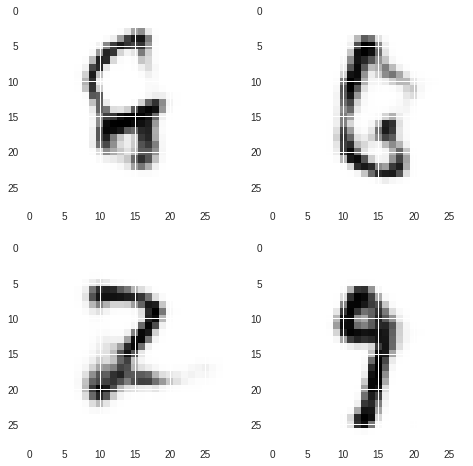

In [139]:
plt.figure(figsize=(8, 8))
for i in range(1, 4 + 1):
    plt.subplot(2, 2, i)
    plt.imshow(sample_image[i].numpy().reshape(28,28))

### latent space

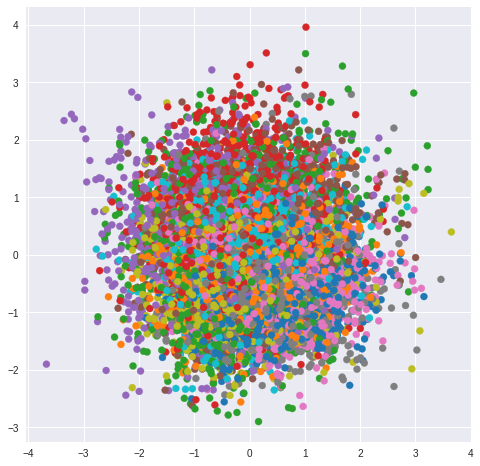

In [140]:
mu, logvar = model.encode(x_train_[:10000])
z = model.reparameterize(mu, logvar)

plt.figure(figsize=(8, 8))
plt.scatter(z[:, 0], z[:, 1], c=y_train[:10000], cmap="tab10")

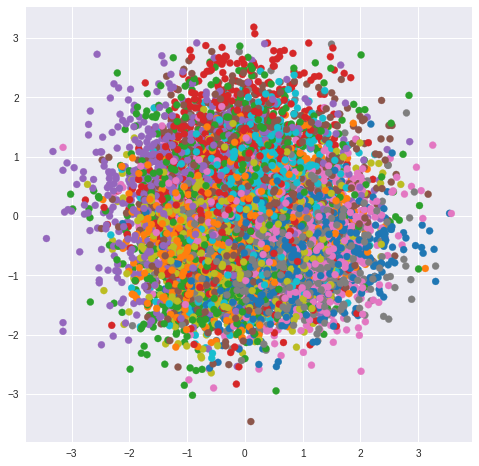

In [141]:
mu, logvar = model.encode(x_test_[:10000])
z = model.reparameterize(mu, logvar)

plt.figure(figsize=(8, 8))
plt.scatter(z[:, 0], z[:, 1], c=y_test[:10000], cmap="tab10")